# 2. k-means Clustering with Semidefinite Programming - 45 points

Clustering is an unsupervised machine learning problem in which we try to partition a given dataset into $k$ subsets based on distance between data points or similarity among them. The goal is to find $k$ centers and assign each data point to one of the centers such that the sum of the square distances between them is minimal [1]. This problem is known to be NP-hard.

## Clustering problem
Given a set of $n$ points in a $d$-dimensional Euclidean space, denoted by

$$
S = \{ \mathbf{s}_i = (s_{i1}, \cdots, s_{id})^\top \in \mathbb{R}^d \mid i = 1, \cdots, n\}
$$

find an assignment of the $n$ points into $k$ disjoint clusters $\mathcal{S} = (S_1, \cdots, S_k)$ whose centers are $\mathbf{c}_j \ (j = 1, \cdots, k)$ based on the total sum of squared Euclidean distances from each point $\mathbf{s}_i$ to its assigned cluster centroid $\mathbf{c}_j$, i.e.,

$$
f(S,\mathcal{S}) = \sum_{j=1}^k \sum_{i=1}^{|S_j|} \|\mathbf{s}_i^{\,j} - \mathbf{c}_j\|^2,
$$

where $|S_j|$ is the number of points in $S_j$, and $\mathbf{s}_i^{\,j}$ is the $i$-th point in $S_j$.

## Lloyd's algorithm for k-means

**1.** Choose initial cluster centers $\mathbf{c}_1, \mathbf{c}_2, \cdots , \mathbf{c}_k$

**2.** Repeat until convergence:

$$
\begin{cases}
\text{Assignment step: } \mathbf{s}_i \text{ belongs to cluster } j, \text{ where } j := \arg\min_{j \in [1,k]} \|\mathbf{s}_i - \mathbf{c}_j\|, \\
\text{Update each cluster center: } \mathbf{c}_j = \frac{1}{|S_j|} \sum_{i=1}^{|S_j|} \mathbf{s}_i^{\,j}
\end{cases}
$$

Note that the algorithm converges to local optima, so the value of $f(S,\mathcal{S})$ can be arbitrarily bad depending on the initialization of the cluster centers.


 **SDP relaxation of the problem:** The work (Peng & Wei, 2007)
proposes an SDP-relaxation to approximately solve the aforementioned
model-free $k$-means clustering problem. The resulting optimization
problem (See section (2) of (Peng & Wei, 2007) for details of this
    relaxation and Lecture 14 for a brief introduction.) takes the standard semidefinite programming form

$$ \mathbf{X}^\star \in \arg \min_{ \mathbf{X} } \bigg\{ \langle \boldsymbol{C}, \mathbf{X} \rangle : ~\underbrace{\mathbf{X} \mathbf{1} =  \mathbf{1}}_{A_1(\mathbf{X}) = b_1},\underbrace{~\mathbf{X}^{\top} \mathbf{1} = \mathbf{1}}_{A_2(\mathbf{X}) = b_2},~\underbrace{\mathbf{X} \geq 0}_{B(\mathbf{X}) \in \mathcal{K}},~\underbrace{\mathrm{Tr}(\mathbf{X}) \leq \kappa, ~\mathbf{X} \in \mathbb{R}^{p\times p} ,~\mathbf{X}\succeq 0 }_{\mathcal{X}} \bigg\} ,
 \tag{Problem 1}$$
where $C \in \mathbb{R}^{p \times p}$ is the
Euclidean distance matrix between the data points.
$\mathrm{Tr}(\mathbf{X}) \leq \kappa$ enforces approximately low-rank
solutions, the linear inclusion constraint $\mathbf{X} \geq 0$ is element-wise
nonnegativity of ${\mathbf{X}}$, the linear equality constraints
$\mathbf{X}\mathbf{1} = \mathbf{1}$ and $\mathbf{X}^{\top} \mathbf{1} = \mathbf{1}$
require row and column sums of $\mathbf{X}$ to be equal to 1's, and
$\mathbf{X} \succeq 0$ means that $\mathbf{X}$ is positive semi-definite. Recall that
$\mathrm{Tr}(\mathbf{X}) = \|\mathbf{X}\|_\ast$ for any positive semi-definite matrix
$\mathbf{X}$.

The SDP in Problem 1 can be reformulated as
$$
\min_{\mathbf{X} \in \mathcal{X}} f(\mathbf{X}) + g_1(A_1(\mathbf{X})) + g_2(A_2(\mathbf{X}))
\qquad\text{subject to}\qquad
B(\mathbf{X}) \in \mathcal{K}
\tag{Equation 2}
$$
where $f(\mathbf{X}) = \langle \boldsymbol{C}, \mathbf{X} \rangle$ is a smooth convex function, $g_1=\delta_{\{b_1\}}(\cdot)$ is the indicator function of singleton $\{b_1\}$, $g_2=\delta_{\{b_2\}}(\cdot)$ is the indicator function of singleton $\{b_2\}$ and ${\mathcal{K}}$ is the positive orthant for which computing the projection is easy.


## 2.1 Theory - 25 points

#### Question 2.1.1 (2 pts) 
Would Frank-Wolfe be a valid approach to solve this problem? Elaborate on your answer. 

**Non-smoothness of the Reformulation:**

Standard Frank-Wolfe (Conditional Gradient) algorithms rely on the assumption that the objective function is smooth (continuously differentiable) with a Lipschitz-continuous gradient to compute the linearization step $\langle \nabla f(\mathbf{X}_k), \mathbf{S} \rangle$.

However, the reformulated problem in **(Equation 2)** incorporates the constraints into the objective function using indicator functions (e.g., $g_1 = \delta_{\{b_1\}}$ and $g_2 = \delta_{\{b_2\}}$). Indicator functions are non-differentiable (non-smooth) as they jump from $0$ to $+\infty$ immediately outside the feasible set.

Because the objective function in (Equation 2) is **non-smooth**, the standard Frank-Wolfe algorithm cannot be directly applied. This necessitates the use of smoothing techniques (likeHomotopy CGM) or splitting methods (like PD3O) that can handle non-smooth terms.

In the sequel, we will attempt to solve this problem with the HomotopyCGM method (**Algorithm 1**) proposed in
(Yurtsever et al., 2018) to handle the non-smooth problems with a
conditional gradient based method.
Another option for solving this problem is PD3O
method (**Algorithm 2**).

#### Question 2.1.2 (3 pts) Characterizing the domain

Show that the domain $\mathcal{X} = \{\mathbf{X}: \mathrm{Tr}(\mathbf{X}) \leq \kappa,~\mathbf{X} \in \mathbb{R}^{p\times p} ,~\mathbf{X} \succeq 0\}$ is a convex set. For this purpose, apply the definition of set convexity.


**Definition of Set Convexity seen in class:**
A set $\mathcal{C}$ is convex if for any two points $\mathbf{X}_1, \mathbf{X}_2 \in \mathcal{C}$ and any scalar $\lambda \in [0, 1]$, the convex combination $\mathbf{Z} = \lambda \mathbf{X}_1 + (1 - \lambda) \mathbf{X}_2$ is also contained in $\mathcal{C}$.

Proof:
Let $\mathbf{X}_1, \mathbf{X}_2 \in \mathcal{X}$ and $\lambda \in [0, 1]$.
By the definition of $\mathcal{X}$, we know that for both $i=1,2$:
1. $\mathbf{X}_i \succeq 0$ (Positive Semi-Definiteness)
2. $\mathrm{Tr}(\mathbf{X}_i) \leq \kappa$ (Trace Constraint)

We need to verify that $\mathbf{Z} = \lambda \mathbf{X}_1 + (1 - \lambda) \mathbf{X}_2$ satisfies these two conditions.

1. Verifying Positive Semi-Definiteness:
The set of positive semi-definite matrices is a convex cone.
Since $\mathbf{X}_1 \succeq 0$ and $\mathbf{X}_2 \succeq 0$, and the coefficients $\lambda$ and $(1-\lambda)$ are non-negative, their linear combination is also positive semi-definite:
$$\mathbf{Z} = \underbrace{\lambda \mathbf{X}_1}_{\succeq 0} + \underbrace{(1 - \lambda) \mathbf{X}_2}_{\succeq 0} \succeq 0$$

2. Verifying the Trace Constraint:
Using the linearity of the trace operator:
$$\mathrm{Tr}(\mathbf{Z}) = \mathrm{Tr}(\lambda \mathbf{X}_1 + (1 - \lambda) \mathbf{X}_2) = \lambda \mathrm{Tr}(\mathbf{X}_1) + (1 - \lambda) \mathrm{Tr}(\mathbf{X}_2)$$

Since $\mathbf{X}_1, \mathbf{X}_2 \in \mathcal{X}$, we know $\mathrm{Tr}(\mathbf{X}_1) \leq \kappa$ and $\mathrm{Tr}(\mathbf{X}_2) \leq \kappa$. Therefore:
$$\mathrm{Tr}(\mathbf{Z}) \leq \lambda \kappa + (1 - \lambda) \kappa = \kappa (\lambda + 1 - \lambda) = \kappa$$

Since $\mathbf{Z}$ satisfies both conditions ($\mathbf{Z} \succeq 0$ and $\mathrm{Tr}(\mathbf{Z}) \leq \kappa$), implies $\mathbf{Z} \in \mathcal{X}$. Thus, the set $\mathcal{X}$ is convex.

#### Question 2.1.3  (8 pts) Gradient of the penalized objective

Given a linear inclusion constraint $Tx \in \mathcal{Y}$,
the corresponding quadratic penalty function is given by
$$\text{QP}_\mathcal{Y}(x) = \text{dist}^2(Tx, \mathcal{Y}) = \min_{y \in \mathcal{Y}} \| y-Tx\|^2.$$
Write down the constraints in (Equation 2) in
the quadratic penalty form. 

Write down the penalized objective based on the formulation in Lecture 13 with penalty parameter $\beta$.



The original constrained problem involves minimizing the smooth objective $f(\mathbf{X}) = \langle \boldsymbol{C}, \mathbf{X} \rangle$ subject to $\mathbf{X} \in \mathcal{X}$ (the PSD cone with bounded trace) and additional constraints (Row Sums, Column Sums, and Non-negativity).

Using the **quadratic penalty method** to move the additional constraints into the objective function (while maintaining the constraint $\mathbf{X} \in \mathcal{X}$), the penalized objective function $F_{\beta}(\mathbf{X})$ is defined as:

$$\min_{\mathbf{X} \in \mathcal{X}} F_{\beta}(\mathbf{X})$$

where $F_{\beta}(\mathbf{X})$ is:

$$
F_{\beta}(\mathbf{X}) = \langle \boldsymbol{C}, \mathbf{X} \rangle + \beta \left[ \frac{1}{2}\|A_1(\mathbf{X})-\mathbf{1}\|_2^2 + \frac{1}{2}\|A_2(\mathbf{X})-\mathbf{1}\|_2^2 + \frac{1}{2}\min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{X}-\mathbf{Y}\|_{\mathrm{F}}^2 \right]
$$

Here:
* $\mathbf{1}$ is the vector of all ones, representing the target value $b_1=b_2=\mathbf{1}$.
* The operator $B(\mathbf{X})$ for the non-negativity constraint $\mathbf{X} \geq 0$ is the **Identity operator**, so $B(\mathbf{X}) = \mathbf{X}$.
* $\mathcal{K}$ is the **non-negative orthant** ($\mathcal{K} = \{ \mathbf{Y} \mid \mathbf{Y} \geq 0 \}$).
* The last term, $\frac{1}{2}\min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{X}-\mathbf{Y}\|_{\mathrm{F}}^2$, is the quadratic penalty for $\mathbf{X} \in \mathcal{K}$, which is equivalent to $\frac{1}{2}\text{dist}^2(\mathbf{X}, \mathcal{K})$.

#### Question 2.1.4 (7 pts) 

Derive the gradient of the penalized objective explicitly  by deriving the gradient and projection specific to (Equation 2) -->. 
(Hint: You can write
$\text{dist}^2(Tx, \mathcal{Y}) = \| y^\ast - Tx \|^2$, where
$y^\ast = \arg \min _{y\in \mathcal{Y}} \| y - Tx \|^2$. and take
the derivative with respect to $\mathbf{X}$ without worrying about
$y^\ast$ depending on $\mathbf{X}$, thanks to Danskin's theorem.

The total gradient of $F_{\beta}(\mathbf{X})$ is the sum of the gradients of its components:
$$\nabla F_{\beta}(\mathbf{X}) = \nabla \left(\langle \boldsymbol{C}, \mathbf{X} \rangle\right) + \beta \cdot \nabla \left[ \frac{1}{2}\|A_1(\mathbf{X})-\mathbf{1}\|_2^2 \right] + \beta \cdot \nabla \left[ \frac{1}{2}\|A_2(\mathbf{X})-\mathbf{1}\|_2^2 \right] + \beta \cdot \nabla \left[ \frac{1}{2}\min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{X}-\mathbf{Y}\|_{\mathrm{F}}^2 \right]$$

#### 1. Gradient of the Linear Objective
$$\nabla \left(\langle \boldsymbol{C}, \mathbf{X} \rangle\right) = \boldsymbol{C}$$

#### 2. Gradients of the Affine Constraint Penalties
For the quadratic penalty $\frac{1}{2}\|T\mathbf{X} - \mathbf{b}\|_2^2$, the gradient is $T^\top (T\mathbf{X} - \mathbf{b})$.

* **Row Sums:** $\nabla \left( \frac{1}{2}\|A_1(\mathbf{X})-\mathbf{1}\|_2^2 \right) = A_1^\top (A_1(\mathbf{X}) - \mathbf{1})$
* **Column Sums:** $\nabla \left( \frac{1}{2}\|A_2(\mathbf{X})-\mathbf{1}\|_2^2 \right) = A_2^\top (A_2(\mathbf{X}) - \mathbf{1})$

#### 3. Gradient of the Non-negativity Penalty (Using Danskin's Theorem)

The penalty term is $P_{non-neg}(\mathbf{X}) = \frac{1}{2}\min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{X}-\mathbf{Y}\|_{\mathrm{F}}^2$.

We first define the optimal $\mathbf{Y}^\ast$ for the inner minimization problem:
$$\mathbf{Y}^\ast = \arg \min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{Y} - \mathbf{X} \|_{\mathrm{F}}^2$$
This is the projection onto the non-negative orthant: $\mathbf{Y}^\ast = \mathrm{proj}_{\mathcal{K}}(\mathbf{X})$.

The penalty term can be written as $P_{non-neg}(\mathbf{X}) = \frac{1}{2} \| \mathbf{X} - \mathbf{Y}^\ast \|_{\mathrm{F}}^2$.

According to **Danskin's Theorem** (as stated in the hint), we can compute the derivative with respect to $\mathbf{X}$ by treating $\mathbf{Y}^\ast$ as constant:

$$\nabla_{\mathbf{X}} \left( \frac{1}{2} \| \mathbf{X} - \mathbf{Y}^\ast \|_{\mathrm{F}}^2 \right) = \mathbf{X} - \mathbf{Y}^\ast$$

Substituting back the definition of $\mathbf{Y}^\ast$:
$$\nabla \left[ \frac{1}{2}\min_{\mathbf{Y} \in \mathcal{K}} \| \mathbf{X}-\mathbf{Y}\|_{\mathrm{F}}^2 \right] = \mathbf{X} - \mathrm{proj}_{\mathcal{K}}(\mathbf{X})$$

#### 4. Final Combined Gradient Expression

Combining all the derived terms, the full gradient of the penalized objective function $F_{\beta}(\mathbf{X})$ is:

$$
\nabla F_{\beta}(\mathbf{X}) = \boldsymbol{C} + \beta \left[ A_1^\top (A_1(\mathbf{X}) - \mathbf{1}) + A_2^\top (A_2(\mathbf{X}) - \mathbf{1}) + (\mathbf{X} - \mathrm{proj}_{\mathcal{K}}(\mathbf{X})) \right]
$$

#### Question 2.1.5 (5 pts) 

The algorithm PD3O (Yan, Ming, 2018) can be used to solve the problem
$ \begin{equation} \min_x f(x) + g(A(x)) + h(x) \end{equation} $ where,
$f(x) = \langle \boldsymbol{C}, x \rangle$ and
$h(x) = \delta_{\mathcal{X}}(x)$. Moreover,
$g(A(x)) = g_1(A_1 (x)) + g_2(A_2 (x)) + \delta_{\mathcal{K}}(Bx)$ for a
suitably defined $g$ and $A$.
#### PD3O splitting method
  ------------------------------------------------------------------------------------------------------------------------------
  **1.** Choose $x^0 \in\mathcal{X}, y^0\in\mathbb{R}^{2p+p^2}$ and $\tau, \sigma >  0$
  
  **2.** For $k=1, 2, \ldots$ perform:
  $$\begin{cases}
  x^{k+1} &= \mathrm{prox}_{\tau h}(x^k - \tau (\nabla f(x^k) + A^\top y^k)) \\
  \tilde x^{k+1} &= 2x^{k+1} - x^k +  \tau \nabla f(x^k)-  \tau \nabla f(x^{k+1})\\
  y^{k+1} &= \mathrm{prox}_{\sigma g^\ast}(y^k + \sigma A(\tilde x^{k+1}))
  \end{cases}$$ 
  
  **3.Output: $~x^k$**
  
  ---------------------------------------------------------------------------------------------------------------------------------


In particular, define
$$\begin{aligned} 
z  = \begin{bmatrix} z_1 \\ z_2 \\ z_3 \end{bmatrix} = \begin{bmatrix}A_1x \\ A_2 x \\ Bx \end{bmatrix},~~~~~A = \begin{bmatrix} A_1 \\ A_2 \\ B \end{bmatrix}~~~~\Rightarrow~~~~~z= A(x),
\end{aligned}\tag{Definition of A}$$
and
$$\tag{Definition of g}
g(z) = \delta_{\{b_1\}}(z_1) + \delta_{\{b_2\}}(z_2) + \delta_\mathcal{K}(z_3).$$

Using the definitions we used for $g$ and $A$
in (Definition of A)
and (Definition of g), show that the $y^{k+1}$ update step of
PD3O can be written in the form
$$y^{k+1} := \begin{bmatrix} y_1^{k+1} \\ y_2^{k+1} \\ y_3^{k+1} \end{bmatrix} = \begin{bmatrix} y_1^k \\ y_2^k \\ y_3^k \end{bmatrix} +\sigma \begin{bmatrix} A_1\tilde x^{k+1} - b_1 \\ A_2\tilde x^{k+1} - b_2 \\ B\tilde x^{k+1} - \mathrm{proj}_{\mathcal{K}}(\sigma^{-1}y_3^k + B\tilde x^{k+1}) \end{bmatrix},$$
and
$$A^\top y^{k+1} = A^\top y^k + \sigma (A_1^\top(A_1 (\tilde x^{k+1}) - b_1) + A_2^\top (A_2 (\tilde x^{k+1}) - b_2) +B^\top(B\tilde x^{k+1} - \mathrm{proj}_{\mathcal{K}}(\sigma^{-1}y^k_3 + B\tilde x^{k+1}))),$$
where the vector $y$ in the dual domain can be written in the form
$y = [y_1~,~y_2~,~y_3]^\top$ with $y_1, y_2\in\mathbb{R}^p$ and
$y_3 \in\mathbb{R}^{p^2}$ (see
also (Definition of A)).

**Hint**: Use Moreau's decomposition to write the update using
$\mathrm{prox}_{g}$ instead of $\mathrm{prox}_{g^\ast}$. In
particular
$$y^{k+1} = \mathrm{prox}_{\sigma g^\ast}(y^k + \sigma A(\tilde x^{k+1})) = y^k + \sigma A( \tilde x^{k+1}) - \sigma \mathrm{prox}_{\sigma^{-1} g}(\sigma^{-1}y^k + A(\tilde x^{k+1})) \\
%&= y^k + \sigma (A_1\tilde x^{k+1} + A_2\tilde x^{k+1} + \tilde x^{k+1}) - \sigma (b_1+b_2+\mathrm{proj}_\mathcal{K}(\sigma^{-1}y^k + \tilde x^{k+1}))$$
The remaining steps are to
use (Definition of A) and find how to compute
$\mathrm{prox}_{g}$ when $g$ is in the decomposed form given
in (Definition of g).

**Answer:**

We start with Moreau's decomposition identity:
$$
y^{k+1} = \mathrm{prox}_{\sigma g^*}(y^k + \sigma A(\tilde x^{k+1})) = y^k + \sigma A(\tilde x^{k+1}) - \sigma \mathrm{prox}_{\sigma^{-1} g}(\sigma^{-1} y^k + A(\tilde x^{k+1}))
$$

Now, recall the definition of $g$:
$$
g(z) = \delta_{\{b_1\}}(z_1) + \delta_{\{b_2\}}(z_2) + \delta_{\mathcal{K}}(z_3)
$$

Since $g$ is separable, its proximal operator decomposes component-wise:
$$
\mathrm{prox}_{\sigma^{-1} g}(w) = \begin{bmatrix}
\mathrm{prox}_{\sigma^{-1} \delta_{\{b_1\}}}(w_1) \\
\mathrm{prox}_{\sigma^{-1} \delta_{\{b_2\}}}(w_2) \\
\mathrm{prox}_{\sigma^{-1} \delta_{\mathcal{K}}}(w_3)
\end{bmatrix}
$$

where $w = \sigma^{-1} y^k + A(\tilde x^{k+1}) = \begin{bmatrix} w_1 \\ w_2 \\ w_3 \end{bmatrix} = \begin{bmatrix} \sigma^{-1} y_1^k + A_1(\tilde x^{k+1}) \\ \sigma^{-1} y_2^k + A_2(\tilde x^{k+1}) \\ \sigma^{-1} y_3^k + B(\tilde x^{k+1}) \end{bmatrix}$

For indicator functions:
- $\mathrm{prox}_{\sigma^{-1} \delta_{\{b_i\}}}(w_i) = b_i$ (since projection onto a singleton)
- $\mathrm{prox}_{\sigma^{-1} \delta_{\mathcal{K}}}(w_3) = \mathrm{proj}_{\mathcal{K}}(w_3)$ (since projection onto non-negative orthant)

Thus:
$$
\mathrm{prox}_{\sigma^{-1} g}(\sigma^{-1} y^k + A(\tilde x^{k+1})) = \begin{bmatrix}
b_1 \\
b_2 \\
\mathrm{proj}_{\mathcal{K}}(\sigma^{-1} y_3^k + B(\tilde x^{k+1}))
\end{bmatrix}
$$

Substituting back into Moreau's decomposition:
$$
y^{k+1} = \begin{bmatrix} y_1^k \\ y_2^k \\ y_3^k \end{bmatrix} + \sigma \begin{bmatrix} A_1(\tilde x^{k+1}) \\ A_2(\tilde x^{k+1}) \\ B(\tilde x^{k+1}) \end{bmatrix} - \sigma \begin{bmatrix} b_1 \\ b_2 \\ \mathrm{proj}_{\mathcal{K}}(\sigma^{-1} y_3^k + B(\tilde x^{k+1})) \end{bmatrix}
$$

Rearranging gives the desired form:
$$
y^{k+1} = \begin{bmatrix} y_1^k \\ y_2^k \\ y_3^k \end{bmatrix} + \sigma \begin{bmatrix}
A_1\tilde x^{k+1} - b_1 \\
A_2\tilde x^{k+1} - b_2 \\
B\tilde x^{k+1} - \mathrm{proj}_{\mathcal{K}}(\sigma^{-1} y_3^k + B\tilde x^{k+1})
\end{bmatrix}
$$

Now for $A^\top y^{k+1}$:
$$
A^\top y^{k+1} = \begin{bmatrix} A_1^\top & A_2^\top & B^\top \end{bmatrix} \begin{bmatrix} y_1^{k+1} \\ y_2^{k+1} \\ y_3^{k+1} \end{bmatrix}
$$

Substitute $y^{k+1}$:
$$
A^\top y^{k+1} = A^\top y^k + \sigma \left[ A_1^\top(A_1\tilde x^{k+1} - b_1) + A_2^\top(A_2\tilde x^{k+1} - b_2) + B^\top(B\tilde x^{k+1} - \mathrm{proj}_{\mathcal{K}}(\sigma^{-1} y_3^k + B\tilde x^{k+1})) \right]
$$

which is the second desired expression.

## 2.2 Practice - 20 points

In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from lib.part2.helpers import *
from lib.part2.Llyod_kmeans import *

### Define operators
We provide 2 operators and their conjugates:
1. `A1`: Linear operator that takes the row sums
2. `At2`: Conjugate of operator A1
3. `A2`: Linear operator that takes the column sums 
4. `At2`: Conjugate of operator A2

### Algorithm 1. Homotopy CGM

You will first implement Homotopy CGM which is defined below for the problem specified in (Equation 2).

  #### Homotopy Conditional Gradient Method (HCGM)
  ---------------------------------------------------------------------------------------------------------------------------------
  **1.** Choose $x^0 \in\mathcal{X}$ and $\beta_0 >  0$
  
  **2.** For $k=1, 2, \ldots$ perform:
  $$
  \begin{cases}
  \gamma_k &= 2/(k+1), ~~\text{and}~~ \beta_k = \beta_0 \sqrt{k+1} \\
  v_k &=  \nabla f(x_k) + \beta_k [A_1^\top (A_1(x_k) - b_1) + A_2^\top (A_2(x_k) - b_2) + (x_k - \text{proj}_{\mathcal{K}}(x_k))]\\
  \hat{x}^k &:= \mathrm{argmin}_{x \in \mathcal{X}} \left \langle  v_k,  x \right \rangle \\
  x^{k+1} &:= (1-\gamma_k)x^k + \gamma_k\hat{x}^k
  \end{cases}
  $$
  
  **3.** Output:$~x^{k+1}$
  
  ---------------------------------------------------------------------------------------------------------------------------------

HCGM is designed for solving constrained minimization problems of the form in (Equation 2). We define such a constrained problem in the following cell, where we specify an objective $f$ and a set of penalities $\{g_i\}$.


In [ ]:
def proj_K(X):
    """Projection onto non-negative orthant (element-wise max with 0)"""
    return np.maximum(X, 0)

f = Function(
    f = lambda X : np.sum(C.flatten()*X.flatten()),
    grad = lambda X: C  
)

g1 = Function(
    f = lambda X : 0.5 * np.linalg.norm((A1(X) - b))**2,
    grad = lambda X: At1(A1(X) - b)  
)

g2 = Function(
    f = lambda X : 0.5 * np.linalg.norm((A2(X) - b))**2,
    grad = lambda X: At2(A2(X) - b)  
)

g3 = Function(
    # Instead of doing Proj, we can use minumum directly because X-Proj_k(X) = minimum(X,0)
    #f = lambda X : 0.5 * np.linalg.norm(X - proj_K(X), 'fro')**2,  # Distance to non-negative orthant
    f = lambda X : 0.5 * np.linalg.norm(np.minimum(X,0), 'fro')**2,  # Distance to non-negative orthant

    #grad = lambda X: 1000*(X - proj_K(X))  # x_k - proj_K(x_k) with 1000 factor
    grad = lambda X: 1000*(np.minimum(X,0))  # x_k - proj_K(x_k) with 1000 factor
)

p = ConstrainedProblem(f = f, penalties = [g1, g2, g3])


**Remark**: The 1000 factor in the term for $(x_k - \text{proj}_{\mathcal{K}}(x_k))$ in Algorithm 1 is in order to obtain a better practical convergence. This basically corresponds to having different penalty parameters for different constraints.

#### Question 2.2.1 (5 pts)

Complete the missing lines in the function
definitions of `HCGM`, which implements Homotopy CGM.

In [4]:
@dataclass
class HCGM_state(OptState):
    x_k: Matrix
    k: int
    beta0: float

In [5]:
def HCGM_initialize(f, Xzero, beta0):
    k = 0
    return HCGM_state(x_k = Xzero, k = k, beta0 = beta0)

For the update recall that a `ConstrainedProblem` can be unpacked as follows:

- `f` which is a `Function` that has a `grad` method
- `penalties` which is a list of functions each having a `grad` method

In [ ]:
def HCGM_update(p : ConstrainedProblem, state : HCGM_state):
    f, penalties = p
    x_k, k, beta0 = state
    
    gamma_k = 2.0 / (k + 1)
    beta_k = beta0 * np.sqrt(k + 1)
    
    
    v_k = f.grad(x_k) + beta_k * (
        penalties[0].grad(x_k) +  
        penalties[1].grad(x_k) +  
        penalties[2].grad(x_k)    
    )
    
    # Linear minimization over X ∈ 𝒳
    X_bar = lmo(v_k, kappa) 
    
   
    X_next = (1 - gamma_k) * x_k + gamma_k * X_bar
    
    return HCGM_state(x_k = X_next, k = k+1, beta0 = beta0)

def lmo(grad, kappa):
    grad_sym = (grad + grad.T) / 2
    # Get smallest (most negative) eigenvalue and eigenvector
    eigvals, eigvecs = eigsh(grad_sym, k=1, which='SA', maxiter=1000)
    
    if eigvals[0] >= 0:
        return np.zeros_like(grad)
    else:
        return kappa * np.outer(eigvecs[:, 0], eigvecs[:, 0])

In [7]:
HCGM = OptAlgorithm(name="HCGM", init_state = HCGM_initialize, state_update = HCGM_update)

#### Question 2.2.2 (2 pts) Run HCGM

Run `HCGM` for $5000$-iterations and plot the result.

In [8]:
X_HCGM, f1_HCGM, f2_HCGM, f3_HCGM, obj_HCGM, iter_HCGM, time_HCGM = run_HCGM(HCGM, p, maxit=5000, beta0=1.0)

  0%|          | 0/5000 [00:00<?, ?it/s]

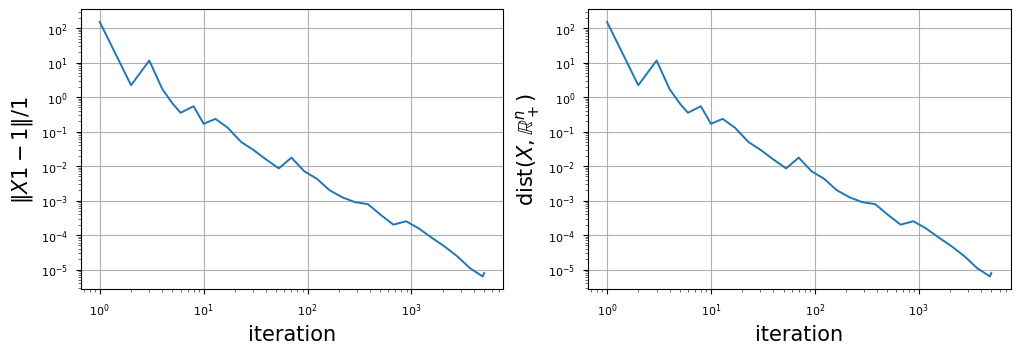

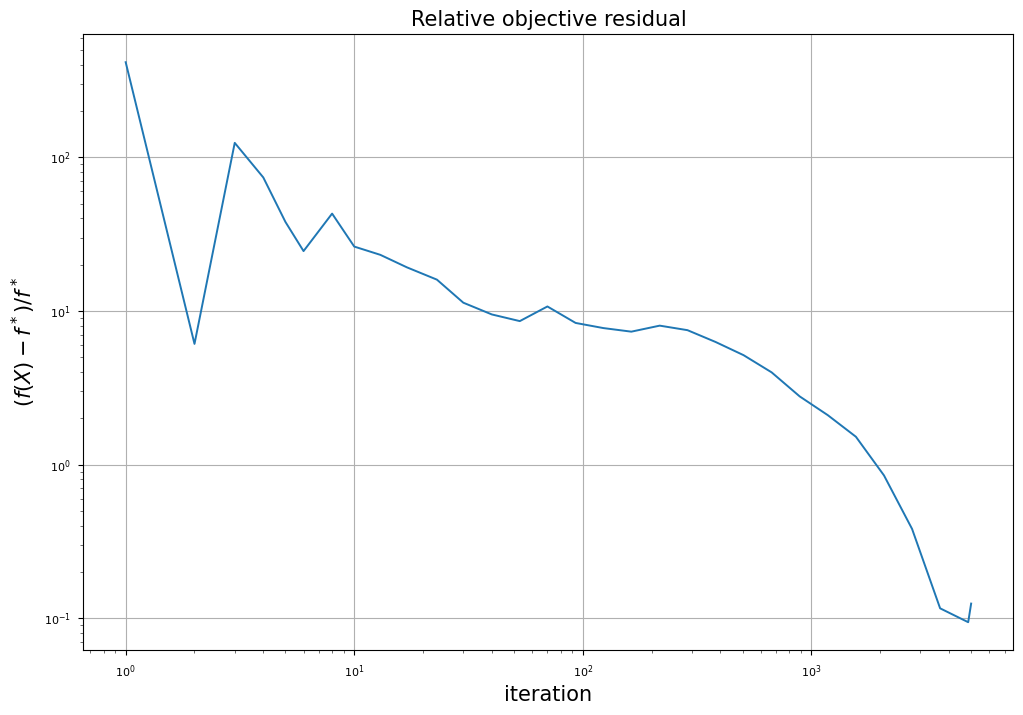

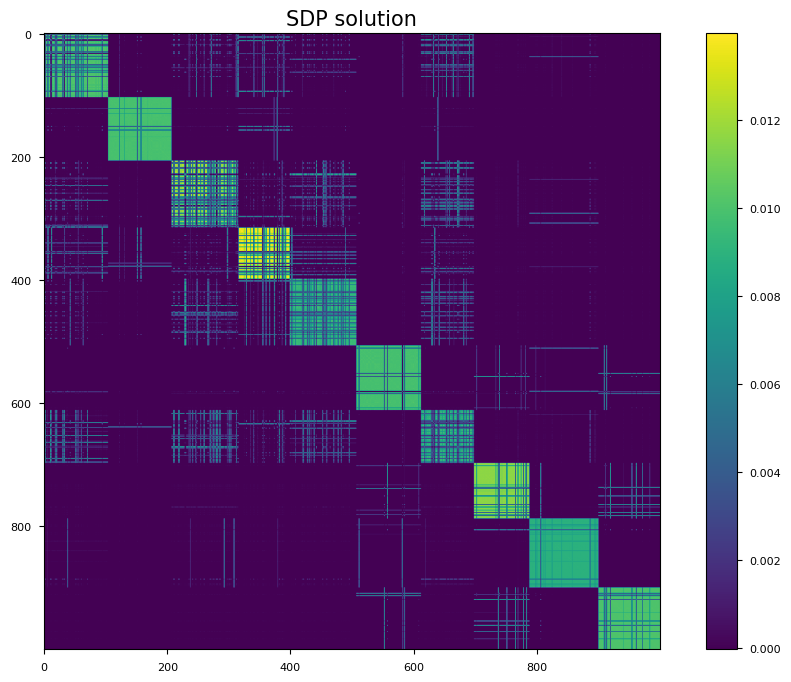

In [9]:
plot_func(iter_HCGM, f1_HCGM,f2_HCGM, obj_HCGM, X_HCGM, opt_val)

<font color=‘red’>

See figures Part2_figure1.png, Part2_figure2.png and Part2.figure3.png

### Algorithm 2. PD3O splitting

To implement PD3O we need to specify the proximal operator of $h$ and $g^*$ as well as the linear operator $A$. We do so in the following cell. Note that the `DualVariable` class is created to keep track of all three dual variable $(y_1,y_2,y_3)$ in a concise way.
In the following cells fill in the proximal operators of $h$ and $g$.

**Hint**: Recall that the proximal operator of an indicator function is a projection. We give you the `projSDP`, which projects onto $\mathcal X$. Further, the proximal operator of a seperable sum is a concatenation of the proximal operators of each term (see the lecture on proximal methods).

In [ ]:
f = Function(
    f = lambda X : np.sum(C.flatten()*X.flatten()),
    grad = lambda X: C  
)

h = Function(
    f = lambda X : 0 if (ispsd(X) and np.trace(X) <= kappa) else float('inf'),
    prox = lambda tau, X: projSDP(X, kappa)  
)

g = Function(
    f = lambda y: 0 if (y.y_1==b) and (y.y_2==b) and (np.all(y.y_3 >=0)) else float('inf'),
    prox = lambda sigma, y: DualVariable(
        b,  
        b,  
        np.maximum(y.y_3, 0)  
    )
)

def A(x):
    return DualVariable(A1(x), A2(x), x)  

def A_T(y):
    return At1(y.y_1) + At2(y.y_2) + y.y_3  

composite = (f, g, h, A, A_T)

#### Question 2.2.3 (5 pts)

Complete the missing lines in the function
definitions of `PD3O` 

**Remarks:** 

- In our case, we advise you to **multiply the step-size for $y_3$ by $10^4$** to obtain a better practical convergence. It is possible to use different dual step sizes, $\{ \sigma_1 , \sigma_2, \sigma_3 \}$.  Such a diagonal variable stepsize is supported through `[sigma1, sigma2, sigma3]*dual_variable`.
- The algorithm needs the proximal operator of $g^*$, the Fenchel dual of $g$, using the Moreau identity express the prox of $g^*$ in terms of the prox of $g$. You will need to multiply by the stepsize `Sigma` and its inverse `Sigma_inv` which we provide in the code below.

In [11]:
@dataclass
class PD3O_state(OptState):
    x_k: Matrix
    y_k: DualVariable(Vector, Vector, Matrix)
    tau: float
    sigma: float

In [ ]:
def PD3O_initialize(composite, x_zero):
    L = 1e2
    tau = 1/L
    # I had to modify the given initialize function, so that it was easier to implement the update function. 
    # However the functionality is still the same, I only used a dual variable
    y_init = DualVariable(
        np.zeros_like(b), 
        np.zeros_like(b),  
        np.zeros_like(x_zero)  
    )
    return PD3O_state(x_k = x_zero, y_k = y_init, tau=tau, sigma=1/(L**2*tau))

def PD3O_update(composite, state):
    f, g, h, A, A_T = composite
    y_k = state.y_k
    x_k, tau, sigma = state.x_k, state.tau, state.sigma
    
    # x^{k+1} = prox_{τh}(x^k - τ(∇f(x^k) + A^⊤y^k))
    next_x_k = h.prox(tau, x_k - tau * (f.grad(x_k) + A_T(y_k)))
    

    x_bar = 2 * next_x_k - x_k  # τ∇f(x^k) and τ∇f(x^{k+1}) cancel out
    
    A_x_bar = A(x_bar)
    
    Sigma = [sigma, sigma, sigma*1e4]
    v = DualVariable(
        y_k.y_1 + Sigma[0] * A_x_bar.y_1,
        y_k.y_2 + Sigma[1] * A_x_bar.y_2,
        y_k.y_3 + Sigma[2] * A_x_bar.y_3
    )
    
    Sigma_inv = [1/sigma, 1/sigma, 1/(sigma*1e4)]
    w = DualVariable(
        Sigma_inv[0] * y_k.y_1 + A_x_bar.y_1,
        Sigma_inv[1] * y_k.y_2 + A_x_bar.y_2,
        Sigma_inv[2] * y_k.y_3 + A_x_bar.y_3
    )
    
    prox_g_w = g.prox(1.0, w)  
    
    # Apply Moreau's identity: y^{k+1} = v - Σ * prox_g(w)
    next_y_k = DualVariable(
        v.y_1 - Sigma[0] * prox_g_w.y_1,
        v.y_2 - Sigma[1] * prox_g_w.y_2,
        v.y_3 - Sigma[2] * prox_g_w.y_3
    )
    
    return PD3O_state(next_x_k, next_y_k, tau, sigma)

In [13]:
PD3O = OptAlgorithm(name="PD3O", init_state = PD3O_initialize, state_update = PD3O_update)

#### Question 2.2.4 (2 pts) Run PD3O

Run `PD3O` for $1000$-iterations and plot the result.

In [43]:
X_PD3O, f1_PD3O, f2_PD3O, obj_PD3O, iter_PD3O, time_PD3O = run_PD3O(PD3O, composite, maxit=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

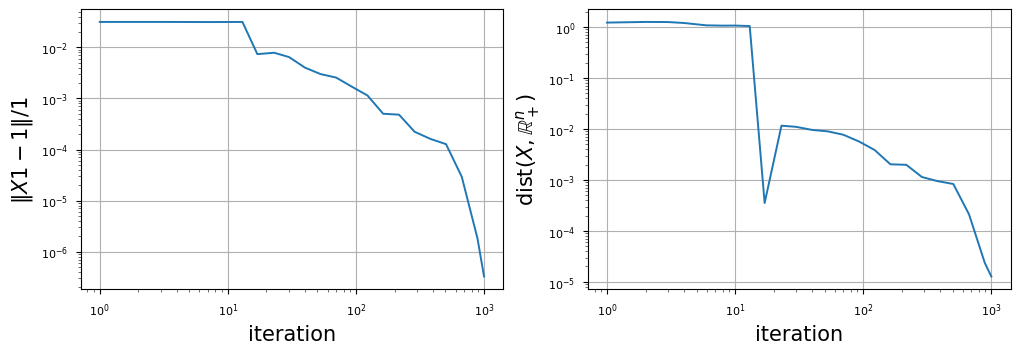

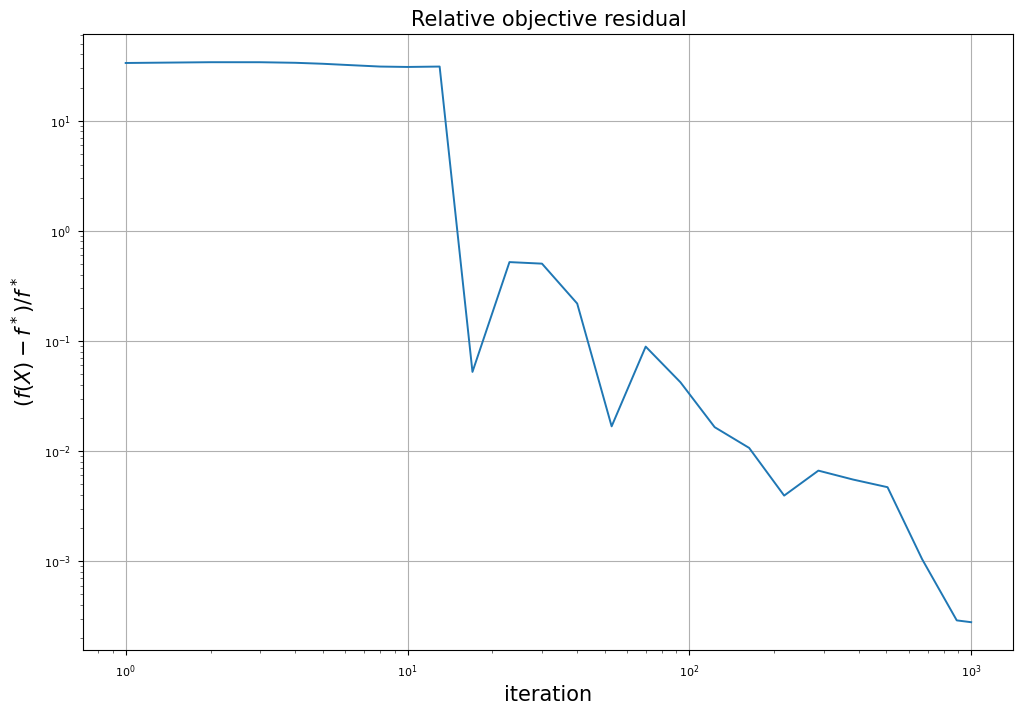

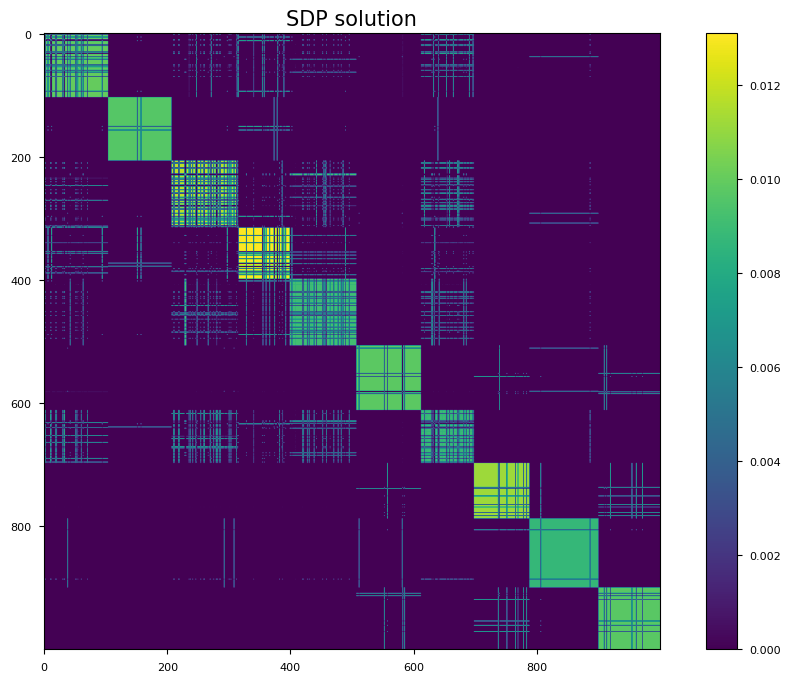

In [44]:
plot_func(iter_PD3O, f1_PD3O,f2_PD3O, obj_PD3O, X_PD3O, opt_val)

<font color=‘red’>

See figures Part2_figure4.png, Part2_figure5.png and Part2.figure6.png

### Comparing HCGM and PD3O

#### Question 2.2.5 (3 pt)

Plot the results with the function `plot_comp`. What are the final objective values? Are they below the optimal value provided to you in `opt_val`? If yes, explain the reason. Answer in the box below.

57.037474593214164 49.95143849288933
[[57.05339187]]


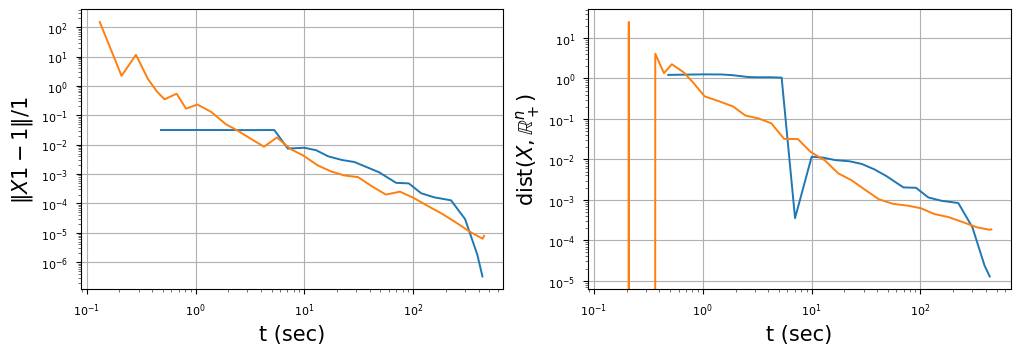

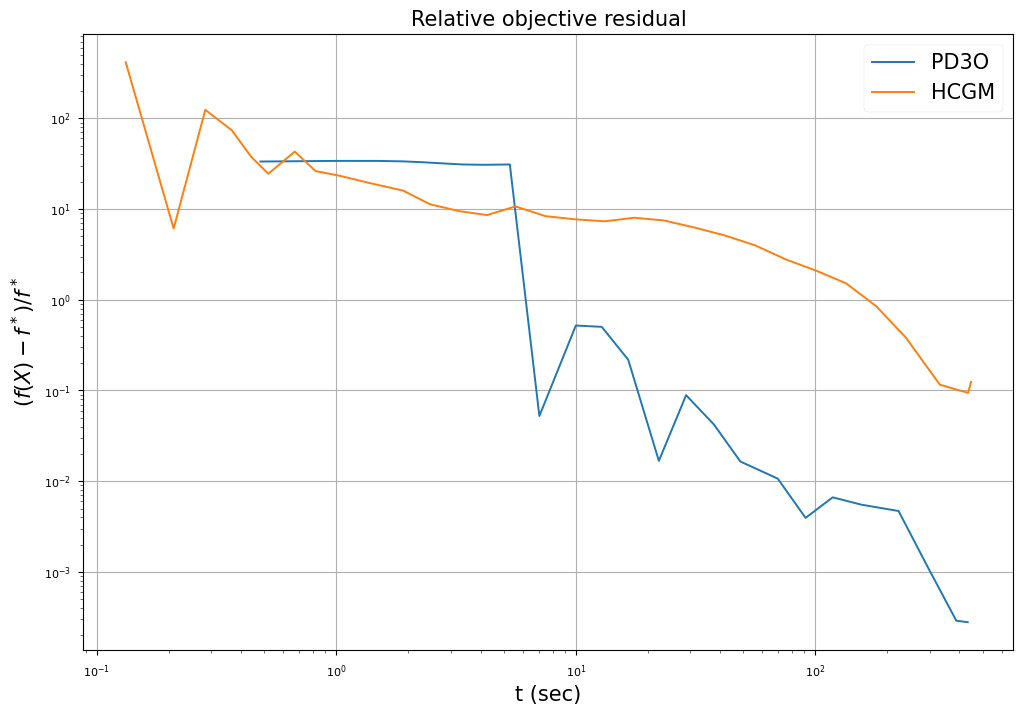

In [77]:
times = (time_PD3O, time_HCGM)
feas1 = (f1_PD3O, f1_HCGM)
feas2 = (f2_PD3O, f3_HCGM)

obj   = (obj_PD3O, obj_HCGM)
print(obj[0][-1],obj[1][-1])
print(opt_val)

plot_comp(times, feas1,feas2, obj, opt_val)


<font color=‘red’>

See figures Part2_figure7.png, Part2_figure9.png

The final jective values are very close to the wanted optimal value. In the second plot we show the algorithms output compared to the provided reference. We can see that the error is very low (0.1 for HCGM and 0.001 PD30), which is a very good score.  
By printing the values of objective, we can see that PD30 is slightly below the optimal value, while HCGM is significantly lower than the optimal value. However since we are plotting the error to the optimal value in the second plot, this is not visible

#### Rounding: Get the assignments from the result of the SDP
Getting the assignments requires going back to the $10$ dimensional space discussed before, and using the coordinates multiplied with the obtained matrix to construct a "denoised" version of the data points. This allows then to find the clusters from these $10$ dimensional data. Our implementation is the python reimplementation of their matlab code which can be found on [github](https://github.com/solevillar/kmeans_sdp).

In [46]:
center_HCGM, assign_HCGM = sdp_rounding(X_HCGM,10, digits)
center_PD3O, assign_PD3O = sdp_rounding(X_PD3O,10, digits)

#### k-means value: HCGM & PD3O

Using the function `value_kmeans`, run the cell below to obtain the $k$-means value before and after running both algorithms. 

    

In [47]:
k_means_before = value_kmeans(digits, labels-1) # k_means value with true labels
k_means_after_HCGM  = value_kmeans(digits, assign_HCGM) # k_means value with assigned lables
k_means_after_PD3O  = value_kmeans(digits, assign_PD3O) # k_means value with assigned lables

print('k-means value initial: {:.4f}'.format(k_means_before))
print('k-means value for HCGM: {:.4f}'.format(k_means_after_HCGM))
print('k-means value for PD3O: {:.4f}'.format(k_means_after_PD3O))

k-means value initial: 150.9680
k-means value for HCGM: 28.7269
k-means value for PD3O: 28.7269


#### Question 2.2.6 (3 pts) k-means value: Lloyd's algorithm

Run the function `kmeans` a few times and report the $k$-means value obtained by Llyod's algorithm. Compare it with the ones obtained by rounding the solution of convex methods `HCGM` and `PD3O`.  Comment on the result.

In [73]:
centers_Lloyd, classifications_Lloyd, k_means_Lloyd = kmeans(digits.T, 10, max_iter=100)#k_means value with Lloyds k-means algorithm

print('k-means value for Lloyd''s algorithm: {:.4f}'.format(k_means_Lloyd))

k-means value for Lloyds algorithm: 28.7347


After running LLoyd's algorithm a few times, it seems that It never comes close to the results obtained by the two convext methods. It even sometimes is over the initial value of 150. However it also happened a few times that LLoyd's algorithm reached a similar value of 28.73.  
The convex methods on the other hand have a very good score for k-means assignment, and they always reach the same value. One surprising thing we detected after lookign at the values is that they assign exactly the same labels/clusters to the same points. This also happens when running PD30 for only 500 iterations, showing that they converge relatively fast to the optimal value. These algorithm are thus deterministic, which makes them much better than LLoyd's because it can be run multiple times without reaching the optimal value.

## OPTIONAL: Additional results for clustering fMNIST Data

### Misclassification rates: HCGM & PD3O


**Dataset:** We use the fashion-MNIST data in (Xiao et al. 2017) which is released as
a possible replacement for the MNIST handwritten digits . Each data
point is a 28x28 grayscale image, associated with a label from 10
classes. Classes
are labeled from 0 to 9. First, we extract the meaningful features from
this dataset using a simple 2 layers neural network with a sigmoid
activation. Then, we apply neural network to 1000 test samples from the
same dataset, which gives us a vector $\eta \in \mathbb{R}^{10}$ where
each entry represents the probability being in that class. Then, we form
the pairwise distance matrix $\boldsymbol{C}$ by using this probability
vectors (In the code, you do not need to worry about any of the processing
    details mentioned here. You are directly given the matrix
    $\mathbf{C}$.).

In [49]:
print('Misclassification rate for HCGM: {:.4f}'.format(misclassification_rate(assign_HCGM, labels)))
print('Misclassification rate for PD3O: {:.4f}'.format(misclassification_rate(assign_PD3O, labels)))

Misclassification rate for HCGM: 0.1250
Misclassification rate for PD3O: 0.1250


### Visualize samples and predicted labels

In [50]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [51]:
def vis_samples(assignment, images, labels):
    assignment=assignment.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    labels = labels-1
    rand_samp = np.random.randint(0,1000,25)
    plt.figure(figsize=(7,7))
    for i,samp in enumerate(rand_samp):
        plt.subplot(5,5,i+1)
        plt.imshow(1-np.reshape(images[samp],[28,28]), cmap=plt.cm.gray)
        plt.title('Pred. {0}\n Orig. {1}'.format(classes[assignment[samp].item()],classes[labels[samp].item()]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

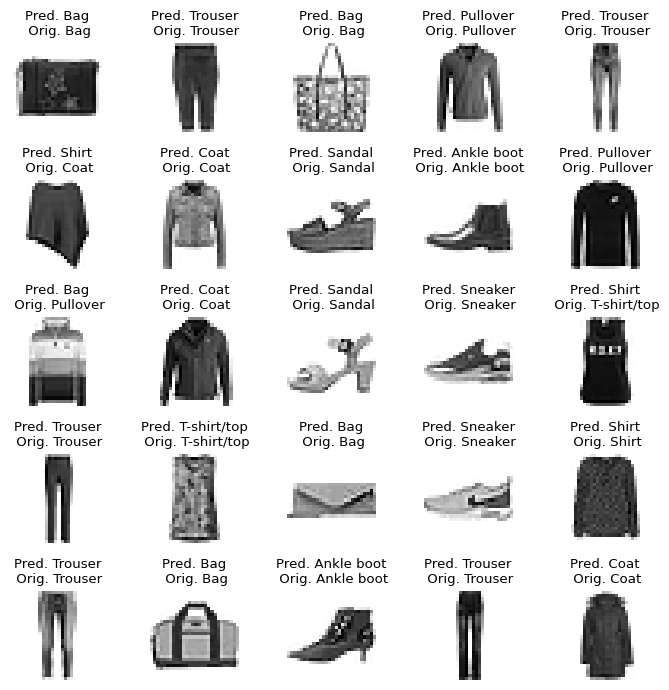

In [52]:
vis_samples(assign_HCGM, images,labels)

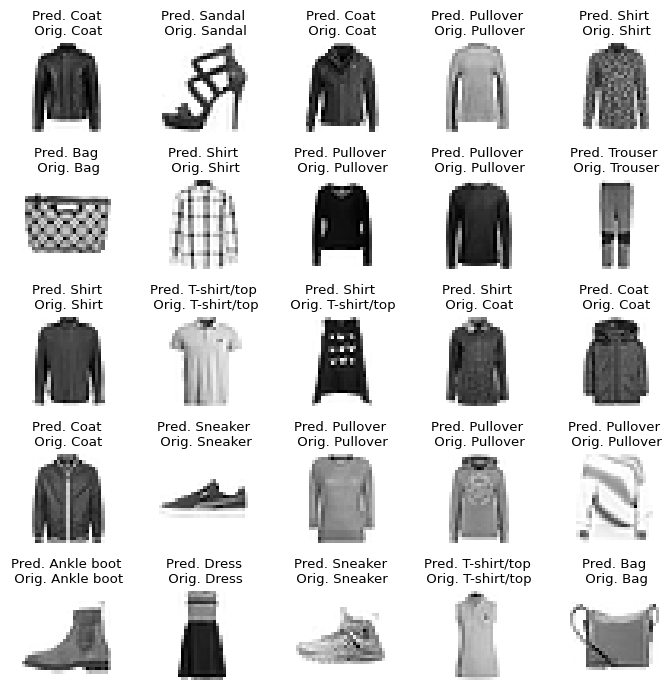

In [53]:
vis_samples(assign_PD3O, images,labels)

## References 

Xiao, Rasul & Vollgraf 2017,  Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms

Peng & Wei 2007, Approximating K-means-type clustering via semidefinite programming

Yurtsever, Fercoq, Locatello & Cevher 2018, A Conditional Gradient Framework for Composite Convex Minimization with Applications to Semidefinite Programming